# Preprocessing the MIDI Dataset

In [29]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

#Set the Correct Dataset Path
dataset_path = '/content/drive/My Drive/LakhMIDI'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
#Check Dataset Contents

import os

# List the contents of the dataset directory
print(os.listdir(dataset_path))

['Jerry_Mungo', 'Jewel', 'Jett', 'Jethro_Tull', 'Jessica_Simpson', 'Jennifer_Warnes', 'Jeremy_Jackson', 'Jefferson_Airplane', 'Jefferson_Starship', 'Jeffrey_Osborne', 'Jeff', 'Jeffrey_Reid_Baker', 'Jennifer_Lopez', 'Jeff_Beck', 'Jennifer_Rush', 'Jeannie_C._Riley', 'Jann_Arden', 'Jan_Hammer', 'Jantje_Koopmans', 'Jars_of_Clay', 'Jan_and_Dean', 'Jason_Donovan', 'Jean_Knight', 'Jay_and_The_Americans', 'Jean_Michel_Jarre', 'Jane_s_Addiction', 'Jamiroquai', 'James_Colin', 'Janis_Ian', 'Janis_Joplin', 'James_Last', 'Jam_and_Spoon', 'Jane_Child', 'Janet_Jackson', 'James_Taylor', 'Jaggerz', 'Jackson_Browne', 'James_Brown', 'Jackson_5', 'James', 'Jackson_Michael', 'Jack_Jones', 'Jamaaladeen_Tacuma', 'Jaco_Pastorius', 'Jackie_Wilson', 'Jackie_DeShannon', 'J.J._Jackson', 'Iron_Maiden', 'Iron_Butterfly', 'Izabella', 'Isaac_Hayes', 'Isabelle_Adjani', 'It_s_a_Beautiful_Day', 'J.J._Cale', 'Jackie_McLean', 'Intermission', 'Ingram_James', 'Interactive', 'Imperial_Teen', 'Information_Society', 'Incognito

### Collect MIDI Files- the Dataset

In [31]:
# Find all .midi and .mid files in the dataset directory
midi_files = []
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith('.midi') or file.lower().endswith('.mid'):
            midi_files.append(os.path.join(root, file))

print(f"Found {len(midi_files)} MIDI files.")

Found 17230 MIDI files.


# Preprocessing MIDI Files -- MIDI files into numerical sequences that the LSTM can understand

### Import Libraries

In [32]:
!pip install pretty_midi numpy

In [33]:
import pretty_midi
import numpy as np

### Extract Notes from MIDI Files

In [34]:
def midi_to_notes(file_path):
    """
    Extracts note data from a MIDI file.
    :param file_path: Path to the MIDI file
    :return: List of (start_time, pitch, velocity, end_time) tuples
    """
    midi = pretty_midi.PrettyMIDI(file_path)
    notes = []
    for instrument in midi.instruments:
        if not instrument.is_drum:  # Ignore drum tracks
            for note in instrument.notes:
                notes.append((note.start, note.pitch, note.velocity, note.end))
    return notes

In [35]:
# Test with the first MIDI file
sample_midi = midi_files[0]
notes = midi_to_notes(sample_midi)
print(f"Extracted {len(notes)} notes from the file.")

Extracted 4638 notes from the file.


### Extract Only Pitches

In [36]:
# Extract pitches from the notes
pitches = [note[1] for note in notes]  # note[1] is the pitch

print(f"First 10 pitches: {pitches[:10]}")

First 10 pitches: [59, 61, 64, 64, 64, 59, 61, 61, 59, 55]


### Normalize Pitch Values

In [37]:
# Normalize pitches
min_pitch = min(pitches)
max_pitch = max(pitches)
normalized_pitches = [(p - min_pitch) / (max_pitch - min_pitch) for p in pitches]

print(f"First 10 normalized pitches: {normalized_pitches[:10]}")

First 10 normalized pitches: [0.4727272727272727, 0.509090909090909, 0.5636363636363636, 0.5636363636363636, 0.5636363636363636, 0.4727272727272727, 0.509090909090909, 0.509090909090909, 0.4727272727272727, 0.4]


# Create Sequences for LSTM

In [38]:
sequence_length = 50  # Number of notes in each sequence

# Create input sequences and their outputs
input_sequences = []
output_notes = []

for i in range(len(normalized_pitches) - sequence_length):
    input_sequences.append(normalized_pitches[i:i + sequence_length])  # 50 notes as input
    output_notes.append(normalized_pitches[i + sequence_length])       # The next note

# Convert to NumPy arrays
input_sequences = np.array(input_sequences)
output_notes = np.array(output_notes)

print(f"Total sequences: {len(input_sequences)}")
print(f"Input sequence shape: {input_sequences.shape}, Output shape: {output_notes.shape}")


Total sequences: 4588
Input sequence shape: (4588, 50), Output shape: (4588,)


### Reshape Data for LSTM

In [39]:
# Reshape input for LSTM
input_sequences = np.reshape(input_sequences, (input_sequences.shape[0], input_sequences.shape[1], 1))

print(f"Reshaped input shape: {input_sequences.shape}")


Reshaped input shape: (4588, 50, 1)


# Build the LSTM Model

In [40]:
!pip install tensorflow

In [41]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

### Define the LSTM Model

In [42]:
def build_model(input_shape):
    """
    Builds and compiles an LSTM model.
    :param input_shape: Shape of the input sequences
    :return: Compiled LSTM model
    """
    model = Sequential([
        LSTM(256, input_shape=input_shape, return_sequences=True),  # First LSTM layer
        LSTM(256),  # Second LSTM layer
        Dense(128, activation='relu'),  # Dense layer for more complexity
        Dense(1, activation='linear')  # Output layer for predicting the next pitch
    ])

    model.compile(optimizer='adam', loss='mse')  # Mean Squared Error for regression
    return model

# Build the model
input_shape = (input_sequences.shape[1], input_sequences.shape[2])  # [time steps, features]
model = build_model(input_shape)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 50, 256)             │         264,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 822,529 (3.14 MB)

 Trainable params: 822,529 (3.14 MB)

 Non-trainable params: 0 (0.00 B)

### Train the Model

In [43]:
batch_size = 64
epochs = 35

history = model.fit(
    input_sequences, output_notes,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2  # Use 20% of the data for validation
)

Epoch 1/35
58/58 ━━━━━━━━━━━━━━━━━━━━ 47s 652ms/step - loss: 0.0546 - val_loss: 0.0118
Epoch 2/35
58/58 ━━━━━━━━━━━━━━━━━━━━ 35s 601ms/step - loss: 0.0063 - val_loss: 0.0087
Epoch 3/35
58/58 ━━━━━━━━━━━━━━━━━━━━ 41s 605ms/step - loss: 0.0062 - val_loss: 0.0080
Epoch 4/35
58/58 ━━━━━━━━━━━━━━━━━━━━ 42s 626ms/step - loss: 0.0063 - val_loss: 0.0066
Epoch 5/35
58/58 ━━━━━━━━━━━━━━━━━━━━ 40s 598ms/step - loss: 0.0063 - val_loss: 0.0062
Epoch 6/35
58/58 ━━━━━━━━━━━━━━━━━━━━ 40s 588ms/step - loss: 0.0060 - val_loss: 0.0063
Epoch 7/35
58/58 ━━━━━━━━━━━━━━━━━━━━ 36s 616ms/step - loss: 0.0059 - val_loss: 0.0054
Epoch 8/35
58/58 ━━━━━━━━━━━━━━━━━━━━ 39s 592ms/step - loss: 0.0055 - val_loss: 0.0054
Epoch 9/35
58/58 ━━━━━━━━━━━━━━━━━━━━ 41s 595ms/step - loss: 0.0053 - val_loss: 0.0049
Epoch 10/35
58/58 ━━━━━━━━━━━━━━━━━━━━ 41s 593ms/step - loss: 0.0056 - val_loss: 0.0047
Epoch 11/35
58/58 ━━━━━━━━━━━━━━━━━━━━ 40s 587ms/step - loss: 0.0057 - val_loss: 0.0052
Epoch 12/35
58/58 ━━━━━━━━━━━━━━━━━━━━ 43

In [44]:
print(history.history.keys())  # Shows available metrics
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

dict_keys(['loss', 'val_loss'])
Final Training Loss: 0.004685554187744856
Final Validation Loss: 0.005072630941867828


### visualize training metrics

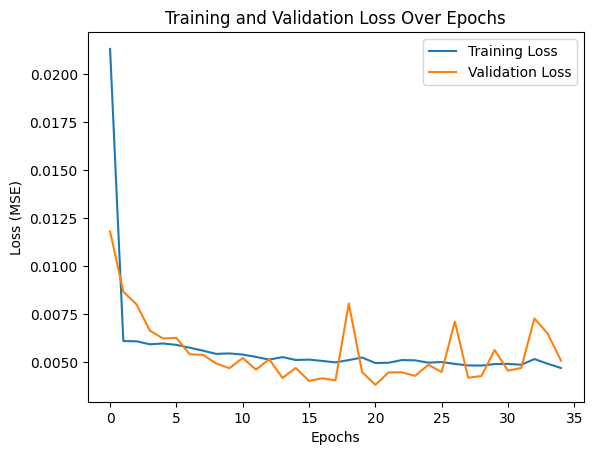

In [45]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()

### Save the Trained Model

In [46]:
model.save('/content/drive/My Drive/music_lstm_model.keras')
print("Model saved successfully!")

Model saved successfully!


# Generate Music

### Seed the Model -- After training, we can use the model to generate new sequences.

In [47]:
# Start with a random sequence from the data

import random

# Pick a random starting sequence
start_idx = random.randint(0, len(input_sequences) - 1)
seed_sequence = input_sequences[start_idx]


### Generate New Notes

In [48]:
# Iteratively predict the next note and add it to the sequence

def generate_music(seed_sequence, num_notes, model):
    """
    Generates a sequence of notes using the trained model.
    :param seed_sequence: Initial input sequence to start the generation
    :param num_notes: Number of notes to generate
    :param model: Trained LSTM model
    :return: Generated sequence of notes
    """
    generated = []
    current_sequence = seed_sequence

    for _ in range(num_notes):
        prediction = model.predict(current_sequence[np.newaxis, :, :])[0, 0]
        generated.append(prediction)

        # Shift the sequence and add the predicted note
        current_sequence = np.roll(current_sequence, -1, axis=0)
        current_sequence[-1] = prediction

    return generated

# Generate 100 new notes
generated_notes = generate_music(seed_sequence, 100, model)
print("Generated notes:", generated_notes[:10])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━

# Convert Generated Notes to MIDI

### Create a Function to Generate MIDI

In [49]:
def notes_to_midi(notes, output_path='generated_music.mid'):
    """
    Converts a sequence of normalized notes back into a MIDI file.
    :param notes: List of normalized pitch values
    :param output_path: Path to save the generated MIDI file
    """
    midi = pretty_midi.PrettyMIDI()
    piano = pretty_midi.Instrument(program=0)  # Acoustic Grand Piano

    # Denormalize pitches (convert back to original range)
    min_pitch = 21  # Minimum MIDI pitch (A0)
    max_pitch = 108  # Maximum MIDI pitch (C8)
    denormalized_pitches = [int(p * (max_pitch - min_pitch) + min_pitch) for p in notes]

    start_time = 0
    duration = 0.5  # Duration of each note (in seconds)
    velocity = 100  # Fixed velocity (volume) for all notes

    for pitch in denormalized_pitches:
        note = pretty_midi.Note(
            velocity=velocity,
            pitch=pitch,
            start=start_time,
            end=start_time + duration
        )
        piano.notes.append(note)
        start_time += duration  # Move to the next note

    midi.instruments.append(piano)
    midi.write(output_path)
    print(f"MIDI file generated and saved at: {output_path}")

### Generate a MIDI File

In [50]:
# Convert generated notes to MIDI
notes_to_midi(generated_notes, output_path='/content/drive/My Drive/generated_music.mid')

MIDI file generated and saved at: /content/drive/My Drive/generated_music.mid


### Play the MIDI File

In [53]:
!apt-get install git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [54]:
!git config --global user.name "riyabasu06"
!git config --global user.email "riyabasu06@gmail.com"

In [56]:
!git clone https://github.com/riyabasu06/Music-Generation-Using-LSTMs.git

fatal: destination path 'Music-Generation-Using-LSTMs' already exists and is not an empty directory.


In [61]:
import shutil

# Paths
project_files = ['LSTM Music Generator.ipynb','/content/drive/My Drive/music_lstm_model.keras','/content/drive/My Drive/generated_music.mid']

# Create the destination directory if it doesn't exist
repo_path = '/content/drive/My Drive/Music-Generation-Using-LSTMs'
#os.makedirs(repo_path, exist_ok=True)

# Copy files to the repo
for file in project_files:
    shutil.copy(file, repo_path)

print("Files moved successfully!")

FileNotFoundError: [Errno 2] No such file or directory: 'LSTM Music Generator.ipynb'